In [ ]:
#Libraries and method import

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv

from scipy.spatial import distance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.manifold import TSNE

from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import PandasTools

from matplotlib import pyplot
from itertools import chain
from IPython.core.display import SVG, HTML
from io import BytesIO
import base64

## Načtení datasetů
Použil jsem csv dataset pro COX2 z CheMBL pro marker IC50 plus active a decoys(ke konci k predikci aktivity a porovnání z předchozími sety) z Dude také pro COX2

In [6]:
def smiles_to_molecule(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except Exception as e:
        return None

Dataset of active ligands on COX2 receptor

In [7]:
suppl_active_ligands = Chem.SDMolSupplier('../ohusak/Data/actives_final.sdf')
NotNull_active_ligands = list(mol for mol in suppl_active_ligands if mol is not None)
cox_active_ligands_df = pd.DataFrame()
cox_active_ligands_df['mol'] = NotNull_active_ligands

Dataset of active ligands from Chembl csv

In [8]:
cox_Chembl_df = pd.read_csv('../ohusak/Data/COX_Chembl.csv', delimiter=';')
cox_Chembl_df['mol'] = cox_Chembl_df['Smiles'].apply(smiles_to_molecule)
cox_Chembl_df = cox_Chembl_df.dropna(subset=['mol'])

## Standardizace

In [9]:
sr = SaltRemover()
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [10]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [11]:
def standardize_dataframe(df):
    df['mol'] = df['mol'].apply(standardize)
    print(df["mol"].isna().sum())
    df = df.dropna(subset=['mol'])

Aplikace standartizace na CheMBL dataset

In [12]:
standardize_dataframe(cox_Chembl_df)
cox_Chembl_df = cox_Chembl_df.dropna(subset=['mol'])

47


Aplikace standartizace na Active 

In [13]:
standardize_dataframe(cox_active_ligands_df)
cox_active_ligands_df = cox_Chembl_df.dropna(subset=['mol'])

0


## Add descriptors, smiles, rings count and fingerprints

V následujícím bloku do obou setů přidávám vybranné molekulové deskriptory. Především pro výpočet Lipenského kalkulu (vybrání druglike molekul), odstranění molekul obsahující PAINS struktury a vytvoření vektoru fingerprintů pro další analýzu.

In [14]:
# Vybranné deskriptory
labels = ['Mol weight', 'HBA', 'HBD', 'logP']
fs = [Descriptors.MolWt, Descriptors.NumHAcceptors, Descriptors.NumHDonors, Descriptors.MolLogP]
limits = [500, 10, 5, 5]

In [15]:
#Lipenského kalkul
def lip(m):
    return [f(m) > l for f,l,lab in zip(fs, limits, labels)]

In [16]:
def set_descriptors(df):
    df['rings'] = df['mol'].apply(lambda m: Chem.GetSSSR(m))
    df['fps'] = df['mol'].apply(lambda m: Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024))
    for f,lab in zip(fs, labels):
        df[lab] = df['mol'].apply(lambda m: f(m))
    df['lip'] = df['mol'].apply(lambda m: sum(lip(m)))

In [17]:
set_descriptors(cox_Chembl_df)

In [18]:
set_descriptors(cox_active_ligands_df)

In [19]:
# Získání druglike molekul z CheMBL datasetu
cox_chembl_druglike_df = cox_Chembl_df[cox_Chembl_df['lip'] == 0]

In [20]:
# Získání druglike molekul z Actives datasetu
cox_active_ligands_druglike_df = cox_active_ligands_df[cox_active_ligands_df['lip'] == 0]

Načtení PAINS

In [26]:
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append(Chem.MolFromSmarts(pattern)) # remove the xml tags

In [27]:
def set_pain_count(mol):
    return any(mol.HasSubstructMatch(pain) for pain in pains)

Aplikace selekce pains na CheMBL dataset

In [28]:
cox_chembl_druglike_df['pain_hits'] = cox_chembl_druglike_df['mol'].apply(lambda m: set_pain_count(m))

C:\Users\husak\anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
cox_chembl_druglike_df = cox_chembl_druglike_df[cox_chembl_druglike_df['pain_hits'] == False]

Aplikace selekce pains na Actives dataset

In [30]:
cox_active_ligands_druglike_df['pain_hits'] = cox_active_ligands_druglike_df['mol'].apply(lambda m: set_pain_count(m))

C:\Users\husak\anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
cox_active_ligands_druglike_df = cox_active_ligands_druglike_df[cox_active_ligands_druglike_df['pain_hits'] == False]

# Trénování modelů

## Vytváření MQN deskriptorů pro datasety, úprava dat a inicializace podpůrných metod

Přidání Molecule Quantum Numbers do Actives datasetu 

In [32]:
MQNs_column_names = ["MQN" + str(i) for i in list(range(1, 43))]

In [33]:
cox_active_ligands_druglike_df[MQNs_column_names] = cox_active_ligands_druglike_df["mol"].apply(lambda m: rdMolDescriptors.MQNs_(m)).to_list()

Přidání Molecule Quantum Numbers do Actives datasetu 

In [34]:
cox_chembl_druglike_df[MQNs_column_names] = cox_chembl_druglike_df["mol"].apply(lambda m: rdMolDescriptors.MQNs_(m)).to_list()

In [35]:
#Metoda pro zobrazení výsledku trénování
def print_regression_metrics(y_t_set, y_prediction):
    print(f"R^2 {explained_variance_score(y_t_set, y_prediction)}")
    print(f"MSE {mean_squared_error(y_t_set, y_prediction)}")

In [36]:
# Trénovací parametry pro random forest
random_forest_param_grid = {
    "max_depth": [15, 21, 25, 31],
    "max_features": [3, 4, 6, 8, 10],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [50, 100, 200]}

In [37]:
# Sada parametrů MLR
linear_regression_param_grid = {"fit_intercept" : [True,False],
                                "copy_X" : [True, False]}

In [38]:
#SVR škálování
sc_X = StandardScaler()
sc_y = StandardScaler()

# SVR parametry
svr_param_grid = {"kernel" : ["linear", "rbf"],
                  "C" : [1, 5, 10]}

In [39]:
#Vyřazení prázdných pChEMBL Value
cox_chembl_druglike_df = cox_chembl_druglike_df[cox_chembl_druglike_df['pChEMBL Value'].isna() == False]

In [40]:
# a way to silence ubiquitous Rdkits "Can't kekulize" errors
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

## Trénování modelů dle MQN

Příprava setů: 1. závislá proměnná, zde jako pChEMBL Value, 2. Nezávislé proměnné MQN deskriptory

In [36]:
chembl_druglike_val = np.array(cox_chembl_druglike_df['pChEMBL Value']).ravel()
chembl_druglike_mqn = np.array(cox_chembl_druglike_df[MQNs_column_names])

Rozdělení na train a test
**chembl_druglike_mqn_train** - trénovací sada MQN deskriptorů
**chembl_druglike_mqn_test** - testovací sada MQN deskriptorů
**chembl_druglike_val_train** - trénovací kolekce pChEMBL Value
**chembl_druglike_val_test** - testovací kolekce pChEMBL Value

In [41]:
chembl_druglike_mqn_train, chembl_druglike_mqn_test, chembl_druglike_val_train, chembl_druglike_val_test = train_test_split(chembl_druglike_mqn, chembl_druglike_val, test_size = 0.20, random_state=1)

### Random forest

In [39]:
random_f_mqns = GridSearchCV(RandomForestRegressor(), random_forest_param_grid, cv = 3)

In [42]:
random_f_mqns.fit(chembl_druglike_mqn_train, chembl_druglike_val_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15, 21, 25, 31],
                         'max_features': [3, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200]})

Predikce trénovacího setu

In [43]:
y_pred_train_random_f_mqns = random_f_mqns.predict(chembl_druglike_mqn_train)

In [44]:
print_regression_metrics(chembl_druglike_val_train, y_pred_train_random_f_mqns)

R^2 0.7064432276280537
MSE 0.37446994717953586


Vizualizace trénovací predikce pro RF - predikované hodnoty/reálné hodnoty

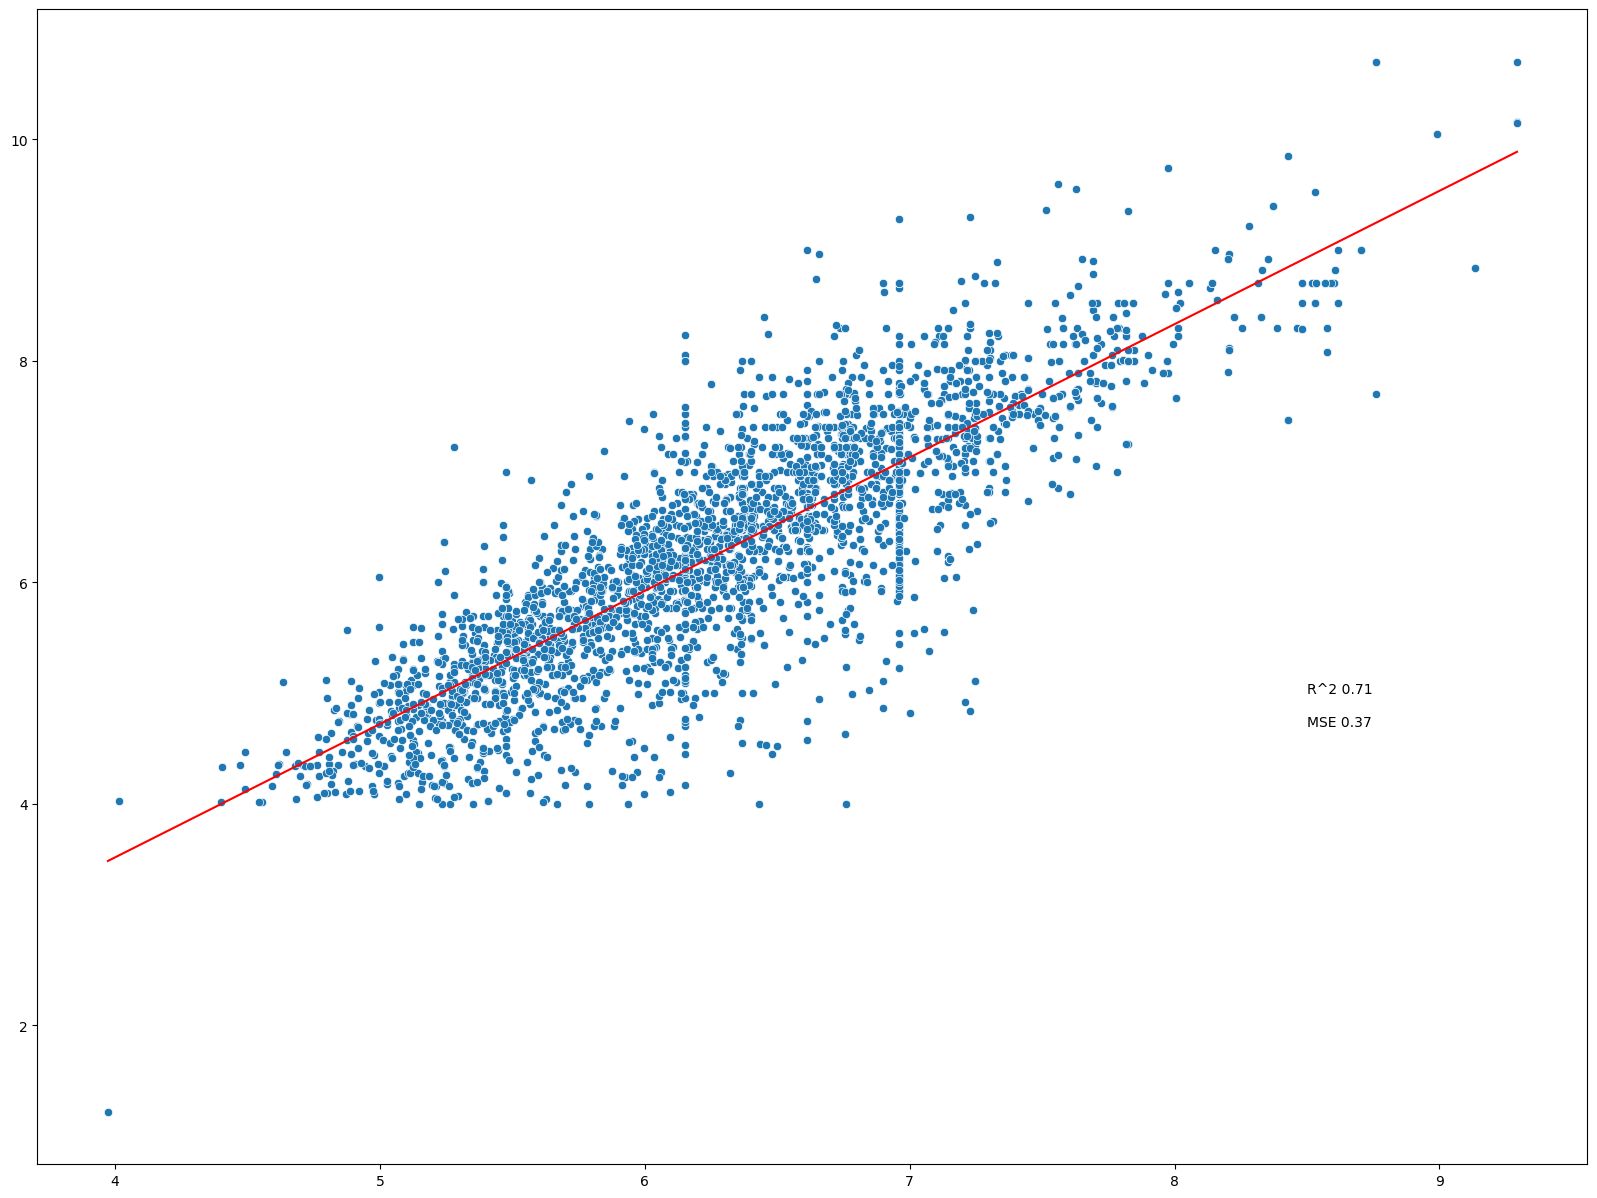

In [45]:
fig, ax = plt.subplots(figsize = (20, 15))

plt.annotate(f"R^2 {explained_variance_score(chembl_druglike_val_train, y_pred_train_random_f_mqns):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(chembl_druglike_val_train, y_pred_train_random_f_mqns):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_random_f_mqns,
                y = chembl_druglike_val_train,
                legend = "brief",
                ax = ax)

plt.plot(np.unique(y_pred_train_random_f_mqns),
         np.poly1d(np.polyfit(y_pred_train_random_f_mqns, chembl_druglike_val_train, 1))(np.unique(y_pred_train_random_f_mqns)),
         color = "red")

Při této vizualizaci se zdá na první pohled, že odhad oproti realitě je poměrně zdařilý

### Multiple linear regression

In [48]:
lin_reg_mqns = GridSearchCV(LinearRegression(), linear_regression_param_grid, cv = 3)

In [49]:
lin_reg_mqns.fit(chembl_druglike_mqn_train, chembl_druglike_val_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]})

Predikce trénovacího setu

In [50]:
y_pred_train_lin_reg_mqns = lin_reg_mqns.predict(chembl_druglike_mqn_train)

In [51]:
print_regression_metrics(chembl_druglike_val_train, y_pred_train_lin_reg_mqns)

R^2 0.2166258254752056
MSE 0.9992557021892268


Vizualizace trénovací predikce pro MLR - predikované hodnoty/reálné hodnoty

<AxesSubplot:>

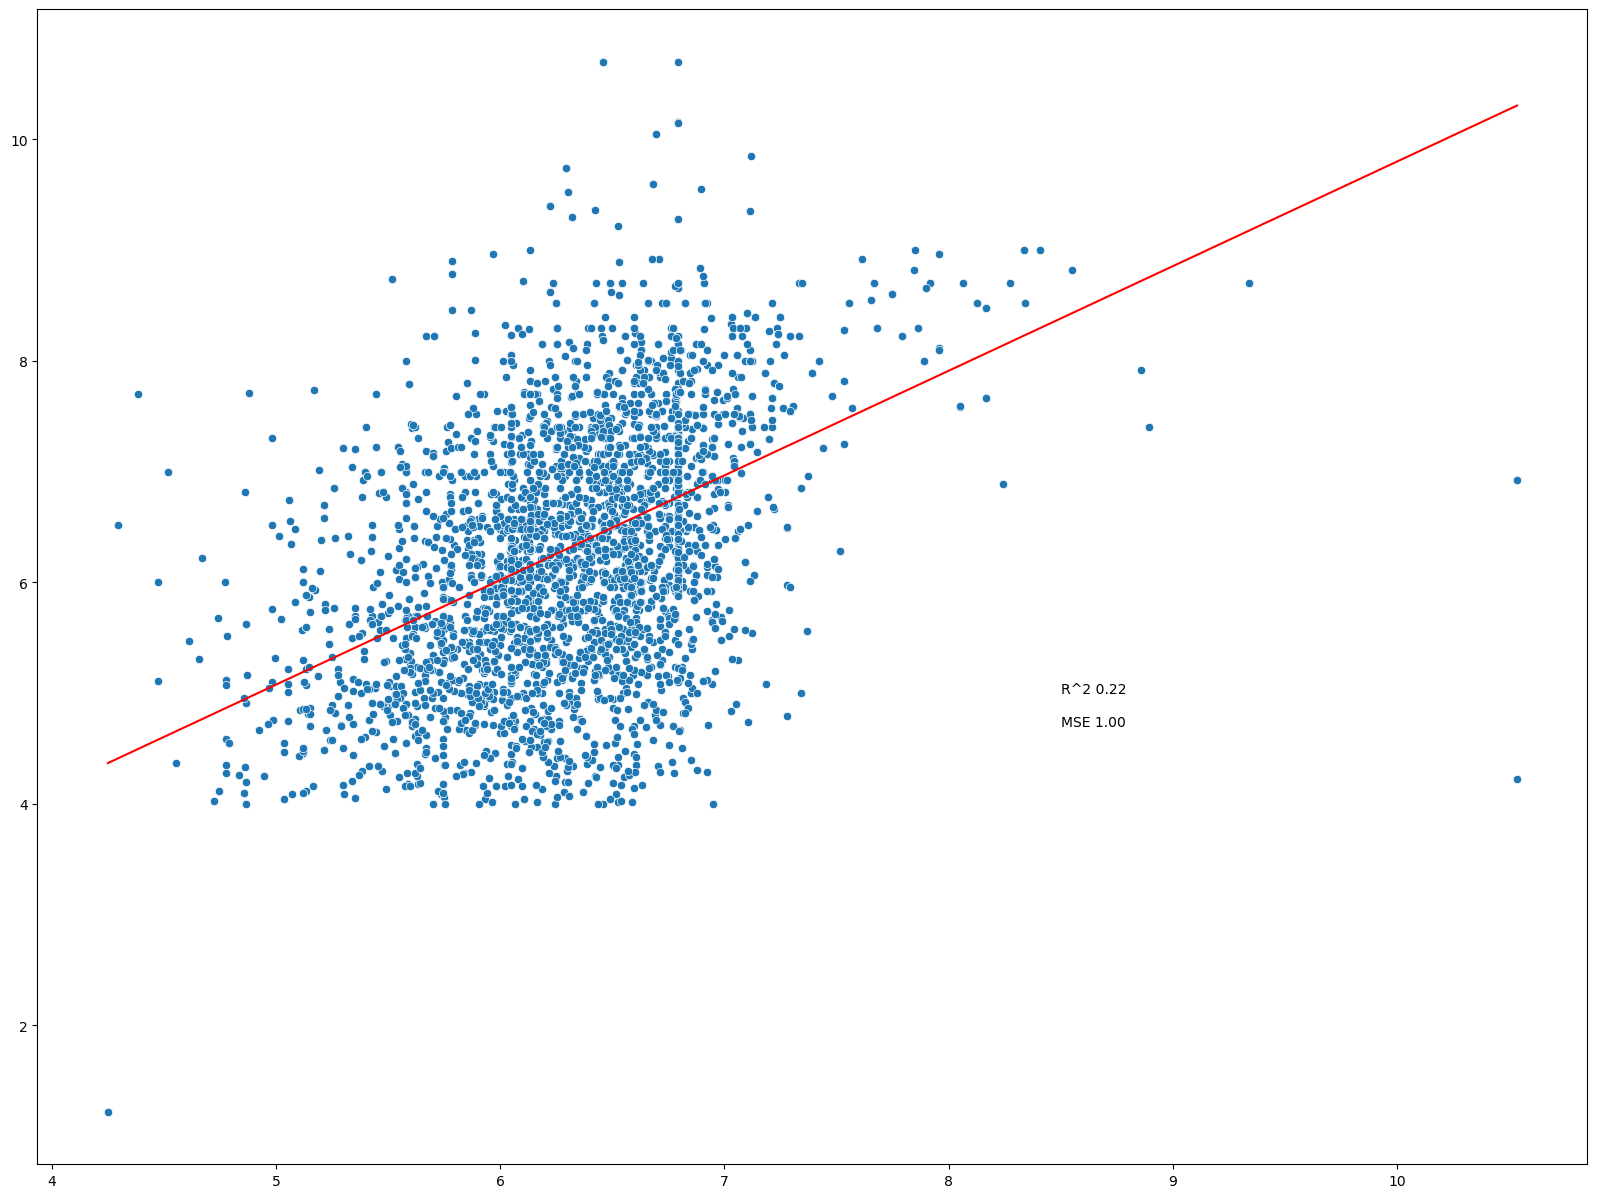

In [52]:
fig, ax = plt.subplots(figsize = (20, 15))
plt.plot(np.unique(y_pred_train_lin_reg_mqns),
         np.poly1d(np.polyfit(y_pred_train_lin_reg_mqns, chembl_druglike_val_train, 1))(np.unique(y_pred_train_lin_reg_mqns)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(chembl_druglike_val_train, y_pred_train_lin_reg_mqns):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(chembl_druglike_val_train, y_pred_train_lin_reg_mqns):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_lin_reg_mqns,
                y = chembl_druglike_val_train,
                legend = "brief",
                ax = ax)

Oproti předchozí vizualizaci a i dle vypočtených hodnot modelu se tato metoda nezdá přiliš vhodná

### Support Vector Regression

In [54]:
chembl_druglike_mqn_train_scaled = sc_X.fit_transform(chembl_druglike_mqn_train)

y_train_scaled = np.array(chembl_druglike_val_train).reshape(len(chembl_druglike_val_train), 1)
y_train_scaled = sc_y.fit_transform(y_train_scaled)
y_train_scaled = y_train_scaled.ravel()

In [56]:
svr_mqns = GridSearchCV(SVR(), svr_param_grid, cv = 3)

In [57]:
svr_mqns.fit(chembl_druglike_mqn_train_scaled, y_train_scaled)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'kernel': ['linear', 'rbf']})

Predikce trénovacího setu

In [59]:
y_pred_train_svr_mqns = svr_mqns.predict(chembl_druglike_mqn_train_scaled)

In [60]:
print_regression_metrics(y_train_scaled, y_pred_train_svr_mqns)

R^2 0.641870889211454
MSE 0.3593675308451179


Vizualizace trénovací predikce pro SVR - predikované hodnoty/reálné hodnoty

<AxesSubplot:>

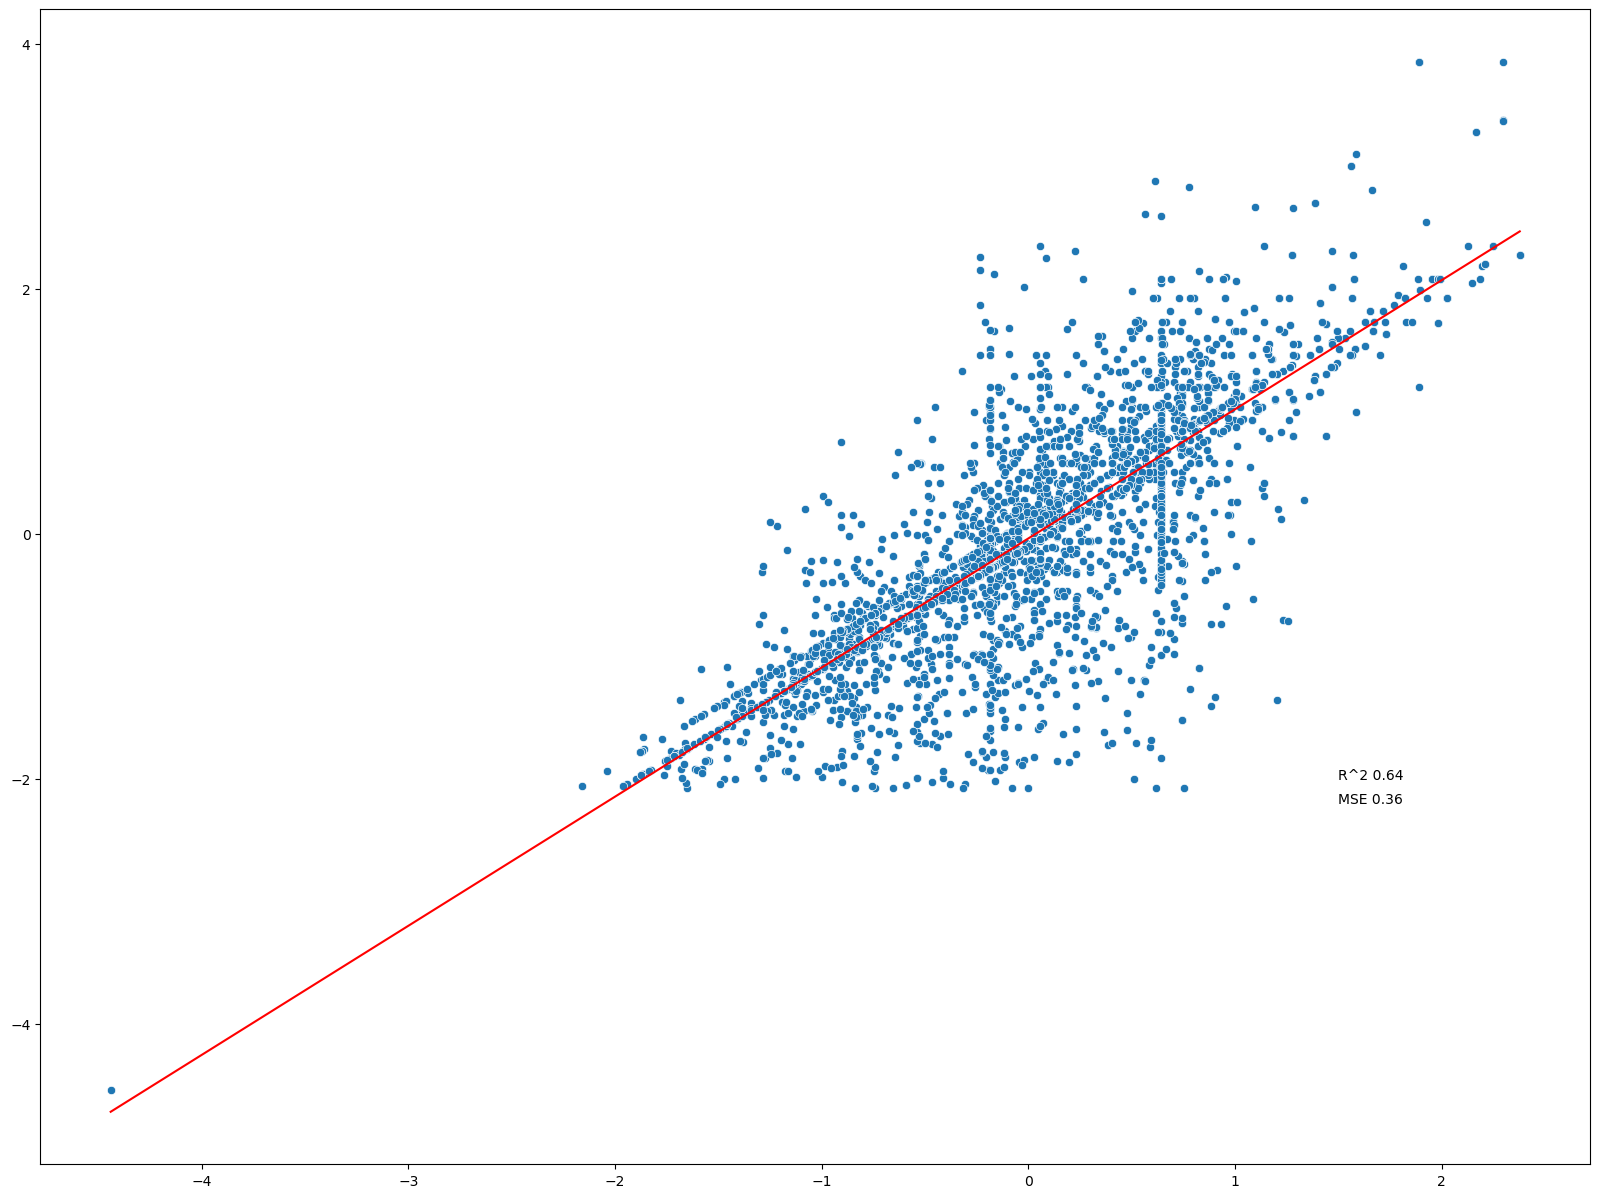

In [61]:
fig, ax = plt.subplots(figsize = (20, 15))
plt.plot(np.unique(y_pred_train_svr_mqns),
         np.poly1d(np.polyfit(y_pred_train_svr_mqns, y_train_scaled, 1))(np.unique(y_pred_train_svr_mqns)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train_scaled, y_pred_train_svr_mqns):.2f}", (1.5, -2))
plt.annotate(f"MSE {mean_squared_error(y_train_scaled, y_pred_train_svr_mqns):.2f}", (1.5, -2.2))
sns.scatterplot(x = y_pred_train_svr_mqns,
                y = y_train_scaled,
                legend = "brief",
                ax = ax)

## Trénování modelů dle Fingerprint vektorů

Příprava setů: 1. závislá proměnná, zde jako pChEMBL Value, 2. Nezávislé proměnné dle pole ECFP (fingerprinty)

In [43]:
ECFP_column_names = ["ECFP" + str(i) for i in list(range(1, 1025))]

In [44]:
X_ECFP = pd.DataFrame(np.array(cox_chembl_druglike_df['fps'].to_list()), columns = ECFP_column_names)

In [45]:
chembl_druglike_val = np.array(cox_chembl_druglike_df['pChEMBL Value']).ravel()

In [ ]:
#Rozdělení dat

In [46]:
X_ECFP_train, X_ECFP_test, y_train, y_test = train_test_split(X_ECFP, chembl_druglike_val, test_size = 0.20, random_state = 1)

### Random forest

In [68]:
rf_ecfp = GridSearchCV(RandomForestRegressor(), random_forest_param_grid, cv = 3)

In [69]:
rf_ecfp.fit(X_ECFP_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15, 21, 25, 31],
                         'max_features': [3, 4, 6, 8, 10],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200]})

Predikce trénovacího setu

In [70]:
y_pred_train_rf_ecfp = rf_ecfp.predict(X_ECFP_train)

In [71]:
print_regression_metrics(y_train, y_pred_train_rf_ecfp)

R^2 0.5646934436898842
MSE 0.5552825008170855


Vizualizace trénovací predikce pro RF(Fingerprint) - predikované hodnoty/reálné hodnoty

Text(0.5, 0, 'Predicted pChEBMBL Value')

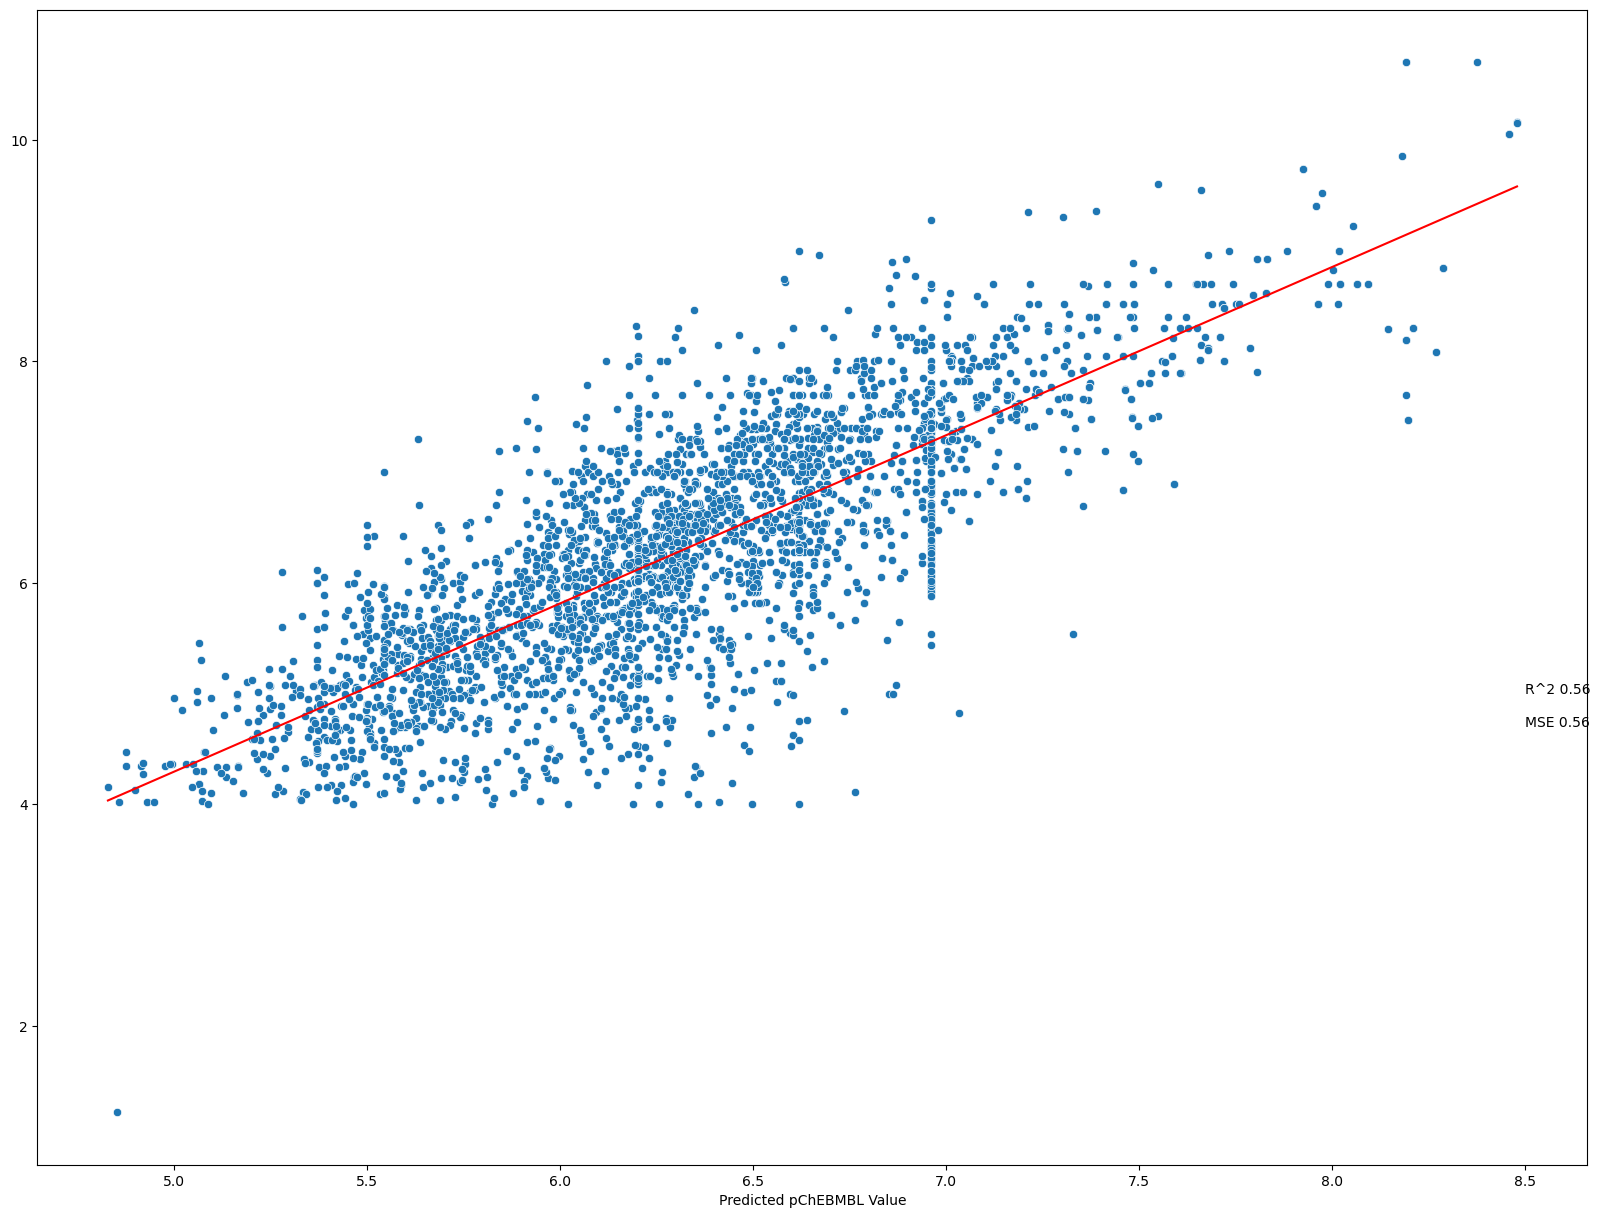

In [72]:
fig, ax = plt.subplots(figsize = (20, 15))
plt.plot(np.unique(y_pred_train_rf_ecfp),
         np.poly1d(np.polyfit(y_pred_train_rf_ecfp, y_train, 1))(np.unique(y_pred_train_rf_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_rf_ecfp):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_rf_ecfp):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_rf_ecfp,
                y = y_train,
                ax = ax)
plt.xlabel("Predicted pChEBMBL Value")

### Mutiple Linear Regression

In [47]:
lin_reg_ecfp = GridSearchCV(LinearRegression(), linear_regression_param_grid, cv = 3)

In [48]:
lin_reg_ecfp.fit(X_ECFP_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]})

Predikce trénovacího setu

In [49]:
y_pred_train_lin_reg_ecfp = lin_reg_ecfp.predict(X_ECFP_train)

In [50]:
print_regression_metrics(y_train, y_pred_train_lin_reg_ecfp)

R^2 0.7320008950434479
MSE 0.34185279770573324


Vizualizace trénovací predikce pro MLR(Fingerprint) - predikované hodnoty/reálné hodnoty

<AxesSubplot:>

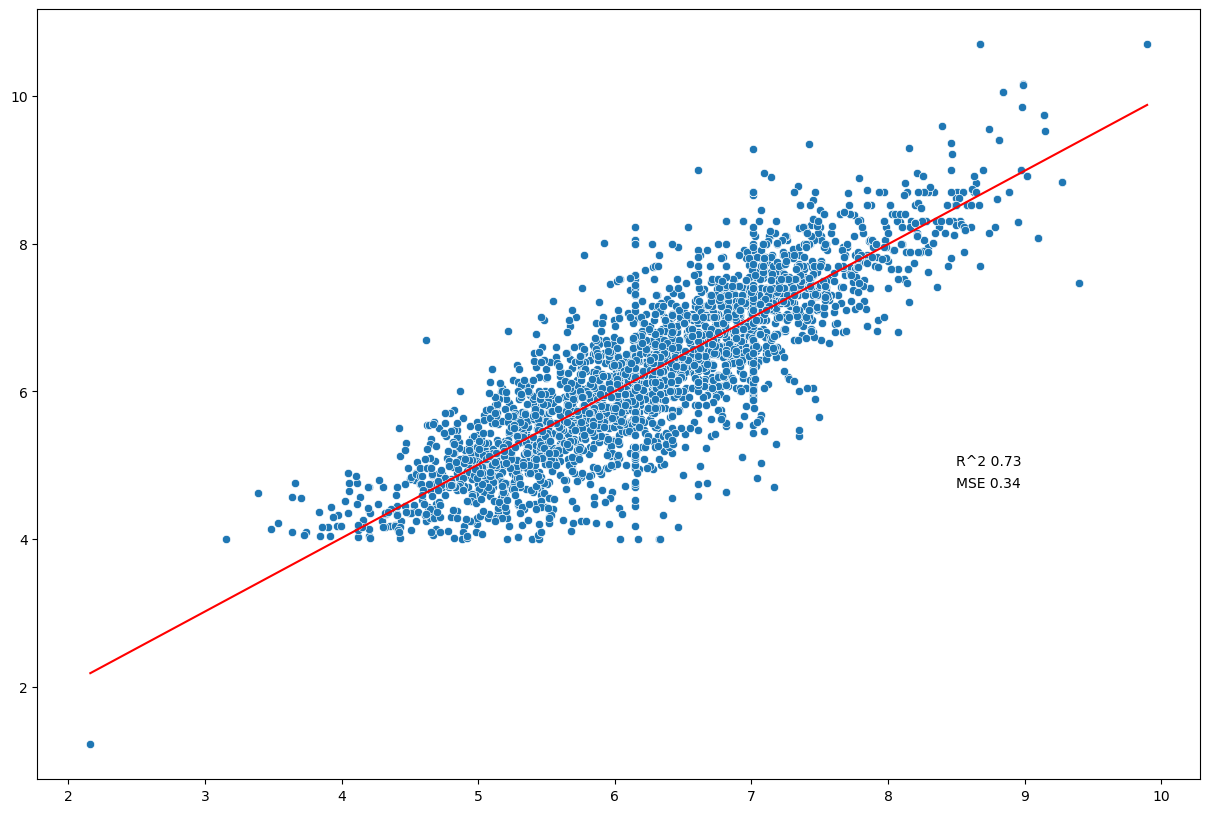

In [78]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_lin_reg_ecfp),
         np.poly1d(np.polyfit(y_pred_train_lin_reg_ecfp, y_train, 1))(np.unique(y_pred_train_lin_reg_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train, y_pred_train_lin_reg_ecfp):.2f}", (8.5, 5))
plt.annotate(f"MSE {mean_squared_error(y_train, y_pred_train_lin_reg_ecfp):.2f}", (8.5, 4.7))
sns.scatterplot(x = y_pred_train_lin_reg_ecfp,
                y = y_train,
                legend = "brief",
                ax = ax)

Vizuálně i výsledkově se tato metoda zdá nejbližší realitě, následnou predikci na datech pro Actives a Decoys provedu pomocí MLR

### Support Vector Regression

In [79]:
X_ECFP_train_scaled = sc_X.fit_transform(X_ECFP_train)
y_train_scaled = np.array(chembl_druglike_val_train).reshape(len(chembl_druglike_val_train), 1)
y_train_scaled = sc_y.fit_transform(y_train_scaled)
y_train_scaled = y_train_scaled.ravel()

In [81]:
y_train_scaled = y_train_scaled.ravel()

In [82]:
svr_ecfp = GridSearchCV(SVR(), svr_param_grid, cv = 3)

In [83]:
svr_ecfp.fit(X_ECFP_train_scaled, y_train_scaled) #Trvá neůměrně dlouho musel jsem zastavit běh programu

KeyboardInterrupt: 

Predikce trénovacího setu

In [ ]:
# Predikce
y_pred_train_svr_ecfp = svr_ecfp.predict(X_ECFP_train_scaled)

In [ ]:
print_regression_metrics(y_train_scaled, y_pred_train_svr_ecfp)

Vizualizace trénovací predikce pro SVR(Fingerprint) - predikované hodnoty/reálné hodnoty

In [ ]:
# Vizualizace
fig, ax = plt.subplots(figsize = (15, 10))
plt.plot(np.unique(y_pred_train_svr_ecfp),
         np.poly1d(np.polyfit(y_pred_train_svr_ecfp, y_train_scaled, 1))(np.unique(y_pred_train_svr_ecfp)),
         color = "red")
plt.annotate(f"R^2 {explained_variance_score(y_train_scaled, y_pred_train_svr_ecfp):.2f}", (1.5, -1.5))
plt.annotate(f"MSE {mean_squared_error(y_train_scaled, y_pred_train_svr_ecfp):.2f}", (1.5, -1.8))
sns.scatterplot(x = y_pred_train_svr_ecfp,
                y = y_train_scaled,
                legend = "brief",
                ax = ax)

# Zpracování predikce z active ligands DUDE

Příprava dat - pro predikci jsem vybral metodu MLR nad polem fingerprintů

In [54]:
cox_active_ligands_ecfp = pd.DataFrame(np.array(cox_active_ligands_df["fps"].to_list()), columns = ECFP_column_names)

In [55]:
y_pred = lin_reg_ecfp.predict(cox_active_ligands_ecfp)
y_pred

array([7.22173218, 3.48468961, 5.60386291, ..., 4.37585091, 7.37617828,
       5.38543102])

In [56]:
cox_active_ligands_ecfp['Smiles'] = cox_active_ligands_df["Smiles"]

Zobrazení sortovaného výsledku, v tomto případě se ovšem jedná o outlinery vypočtená hodnota je extrémně vysoká

In [58]:
cox_active_ligands_ecfp["pChEMBL Value"] = y_pred
cox_active_ligands_ecfp.sort_values("pChEMBL Value", ascending = False, inplace = True)
cox_active_ligands_ecfp.head(10)

,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,ECFP9,ECFP10,...,ECFP1017,ECFP1018,ECFP1019,ECFP1020,ECFP1021,ECFP1022,ECFP1023,ECFP1024,Smiles,pChEMBL Value
2824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CNc1ccc(-c2nc(C(F)(F)F)cn2-c2ccc(S(C)(=O)=O)cc...,8.205317e+11
1966,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CS(=O)(=O)c1ccc(C2=C(c3cccnc3)C(=O)OC2)cc1,8.205317e+11
3046,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,CC(C)NC(=O)c1nc(-c2ccccc2)n(-c2ccc(S(N)(=O)=O)...,8.205317e+11
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,CC(C)[C@@H]1CC[C@]2(C)[C@H](C(=O)C=C3[C@@H]4[C...,8.205317e+11
4747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CS(=O)(=O)c1ccc(/C=C(/C(=O)O)c2cccc(Br)c2)cc1,8.205317e+11
3589,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CS(=O)(=O)c1ccc(-c2cnn(CC3CC3)c(=O)c2-c2ccccc2...,8.205317e+11
2421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cc1cccc(C2C3CCc4ccccc4C3=NN2c2ccc(S(N)(=O)=O)c...,8.205317e+11
6684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Cc1cc(=O)c(Oc2ccc(Cl)cc2F)c(-c2ccc(S(C)(=O)=O)...,8.205317e+11
5214,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CS(=O)(=O)c1ccc2c(Sc3ccc(F)cc3F)c(C#N)[nH]c2c1,8.205317e+11
3287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CCN1C[C@]2(COC)[C@H](O)C[C@@H](OC)[C@@]34[C@@H...,8.205317e+11


Nastavení hranice pChEMBL Value pro uznání ligandu jako active pro další práci

In [59]:
cox_active_ligands_ecfp["potential_ligand"] = (cox_active_ligands_ecfp["pChEMBL Value"] >= 6.5).map({False: "inactive", True: "active"})
cox_active_ligands_ecfp_ligands = cox_active_ligands_ecfp.loc[cox_active_ligands_ecfp["potential_ligand"] == "active"].copy(deep = True)

Rozdělení na active/neactive - počty

In [60]:
cox_active_ligands_ecfp["potential_ligand"].value_counts()

inactive    4305
active      3045
Name: potential_ligand, dtype: int64

## Spojení zdrojů

In [93]:
cox_active_ligands_ecfp['source'] = "COX2 ligands"

In [94]:
X_ECFP['pChEMBL Value'] = cox_chembl_druglike_df['pChEMBL Value']

In [95]:
chembl_datasource_df = X_ECFP[X_ECFP['pChEMBL Value'].isna() == False]

In [96]:
chembl_datasource_df["potential_ligand"] = (chembl_datasource_df["pChEMBL Value"] >= 6.5).map({False: "inactive", True: "active"})

C:\Users\husak\anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
chembl_datasource_df['source'] = "CheMBL"

C:\Users\husak\anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
combined_df = cox_active_ligands_ecfp[ECFP_column_names + ["pChEMBL Value", "source", "potential_ligand"]].append(chembl_datasource_df, ignore_index = True)

## Výpočet distanční matice

In [185]:
sparse_mat = distance.pdist(combined_df[ECFP_column_names + ["pChEMBL Value"]], metric = "jaccard")
dist_mat = distance.squareform(sparse_mat)

In [186]:
#pd.DataFrame(dist_mat).to_csv("dist_mat_project.csv") - už jsem si jí jednou uložil (má asi 1,5GB)

## Vizualizace pomocí TSNE dle zdroje a aktivity

In [190]:
clf = TSNE(n_components = 2, metric = "precomputed")
tsne = clf.fit_transform(dist_mat)

C:\Users\husak\anaconda3\envs\school\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\husak\anaconda3\envs\school\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\husak\anaconda3\envs\school\lib\site-packages\sklearn\manifold\_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [191]:
combined_df[["tsne_x", "tsne_y"]] = tsne.tolist()

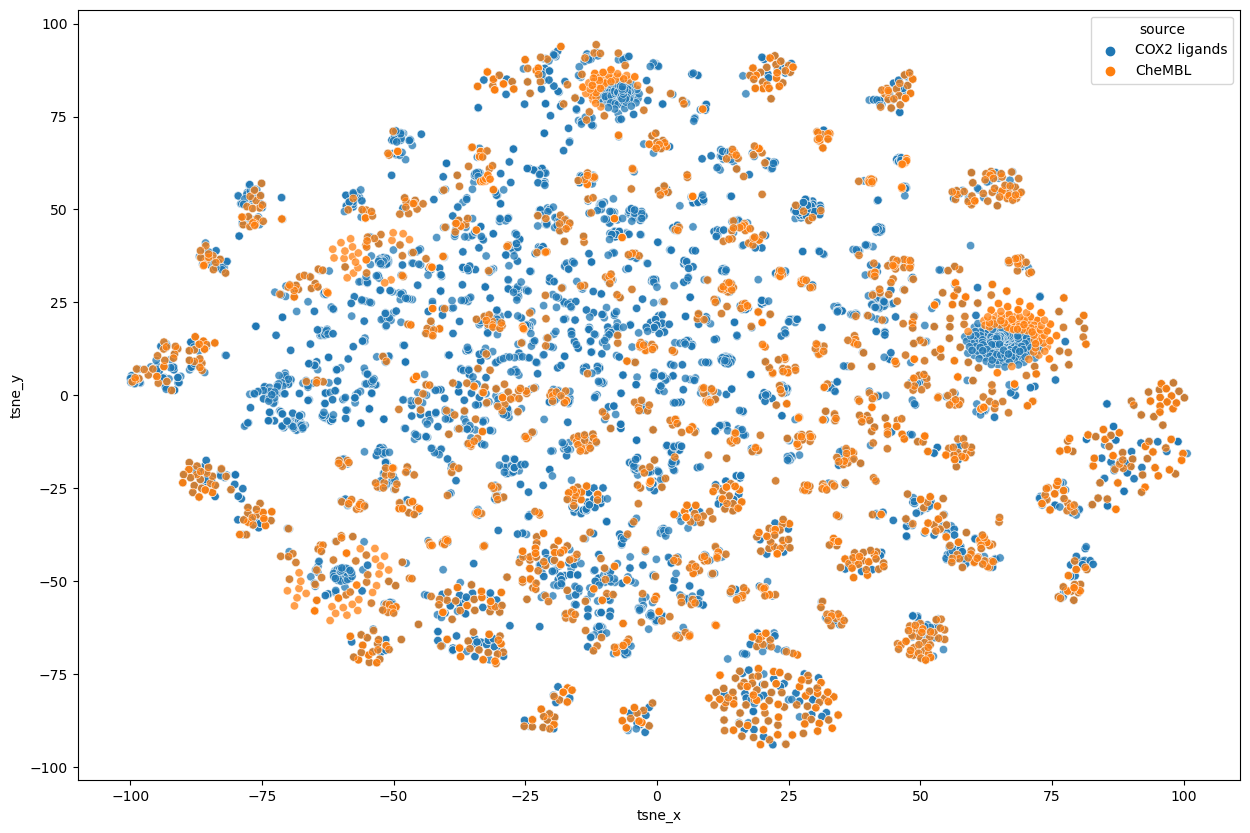

In [192]:
fig, ax = plt.subplots(figsize = (15, 10))
plot = sns.scatterplot(x = "tsne_x", y = "tsne_y", data = combined_df, hue = "source", legend = "brief", ax = ax, alpha = 0.75)

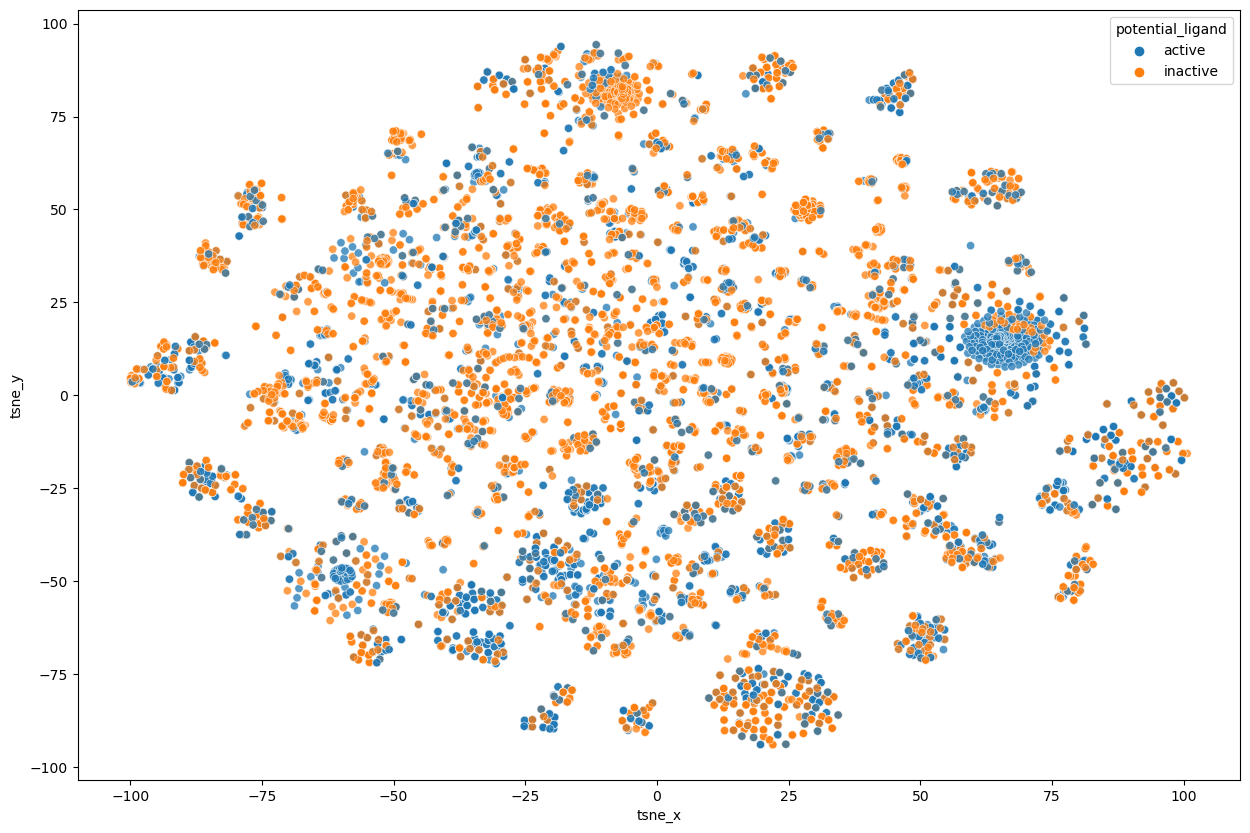

In [193]:
fig, ax = plt.subplots(figsize = (15, 10))
plot = sns.scatterplot(x = "tsne_x", y = "tsne_y", data = combined_df, hue = "potential_ligand", legend = "brief", ax = ax, alpha = 0.75)

# Přidání decoys

Postupoval jsem stejně jako s předchozími datasety i v případě Decoys z DUDE (blíže to nerozepopisuji)

In [100]:
suppl = Chem.SDMolSupplier('../ohusak/Data/decoys_final.sdf.gz')

decoys_df = PandasTools.LoadSDF('../ohusak/Data/decoys_final.sdf.gz')

decoys_df = PandasTools.LoadSDF('../ohusak/Data/decoys_final.sdf.gz', smilesName='SMILES')
print(decoys_df.head())

             ID                              SMILES  \
0  ZINC06244154                N#CCCSc1nncc2ccccc12   
1  ZINC13947244               CCC1CCCCN1S(=O)(=O)CC   
2  ZINC01391812      CC(=O)c1ccc(/C(C#N)=C/N(C)C)s1   
3  ZINC01703772          CCS(=O)(=O)C1CCC1OC(C)(C)C   
4  ZINC01737245  CC1=C(CCC#N)C(=O)C(CCC#N)C(C)(C)C1   

                                               ROMol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...  


In [101]:
decoys_df.rename(columns={'ROMol': 'mol'}, inplace=True)

In [102]:
standardize_dataframe(decoys_df)
decoys_df = decoys_df.dropna(subset=['mol'])

53


In [103]:
decoys_df['fps'] = decoys_df['mol'].apply(lambda m: Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024))

In [105]:
decoys_ecfp = pd.DataFrame(np.array(decoys_df["fps"].to_list()), columns = ECFP_column_names)

### Predikce MLR nad fingerprinty decoys

In [106]:
y_decoys_pred = lin_reg_ecfp.predict(decoys_ecfp)
y_decoys_pred

array([7.19393431e+00, 2.04905780e+00, 8.20531674e+11, ...,
       3.93271777e+00, 2.48549200e+00, 4.46296864e+00])

In [107]:
decoys_ecfp["pChEMBL Value"] = y_decoys_pred
decoys_ecfp.sort_values("pChEMBL Value", ascending = False, inplace = True)
decoys_ecfp.head(10)

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

       ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  ECFP10  \
3429       0      0      0      0      1      0      0      0      0       0   
295        0      0      0      0      0      0      0      0      0       0   
12287      0      0      0      0      0      0      0      0      0       0   
16100      0      0      0      0      0      1      0      0      0       0   
16099      0      0      0      0      0      1      0      0      0       0   
10108      0      0      0      0      0      0      0      0      0       0   
9281       0      0      0      0      1      0      0      0      0       0   
23250      0      0      0      0      0      0      0      0      0       0   
12005      0      0      0      0      0      0      0      0      0       0   
2665       0      0      0      0      0      0      0      0      0       0   

       ...  ECFP1016  ECFP1017  ECFP1018  ECFP1019  ECFP1020  ECFP1021  \
3429   ...         0         0         0     

In [108]:
decoys_ecfp["potential_ligand"] = (decoys_ecfp["pChEMBL Value"] >= 6.5).map({False: "inactive", True: "active"})

In [109]:
decoys_ecfp["potential_ligand"].value_counts()

inactive    15024
active       8328
Name: potential_ligand, dtype: int64

In [110]:
decoys_ecfp['source'] = "COX2 decoys"

### Zkombinování všech datasetů a vizualizace

In [111]:
combined_with_dec_df = combined_df[ECFP_column_names + ["pChEMBL Value", "source", "potential_ligand"]].append(decoys_ecfp, ignore_index = True)

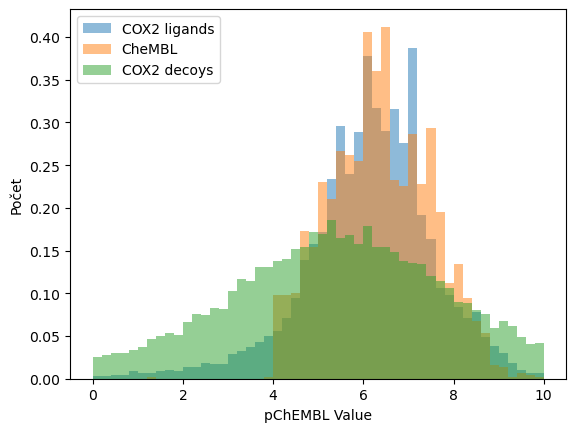

In [112]:
for source in combined_with_dec_df['source'].unique():
    subset = combined_with_dec_df[combined_with_dec_df['source'] == source]
    plt.hist(subset['pChEMBL Value'], bins=50, alpha=0.5, label=source, range=(0, 10), density=True)

plt.xlabel('pChEMBL Value')
plt.ylabel('Počet')
plt.legend()
plt.show()

K vizualizaci a porovnání datasetů, které jsem použil, jsem vybral zobrazení pomocí normovaného histogramu. Při výočtu distanční matice všech látek jsem se opět dostal k nesmyslným časům. A i na tomto obrázku lze spatřit to co jsem si chtěl potvrdit. Model nám relativně správně predikuje aktivitu jak u Actives, tak u Decoys (která by měla být nižší)

# Analýza scaffoldů

Pracuji s datasetem aktivních ligandů u kterých je predikovaná aktivita a vybírám deset nejčastějčích scaffoldů, které pak zobrazuji v tabulce

In [51]:
def scaffold(mol):
    if mol is None:
        return ""
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    smile = Chem.MolToSmiles(scaff)
    return smile

In [52]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [61]:
cox_active_ligands_from_MLR = cox_active_ligands_ecfp.loc[cox_active_ligands_ecfp['potential_ligand'] == 'active']

In [62]:
cox_active_ligands_from_MLR['mol'] = cox_active_ligands_from_MLR['Smiles'].apply(lambda x: smiles_to_molecule(x))

C:\Users\husak\anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
cox_active_ligands_from_MLR = cox_active_ligands_from_MLR.loc[cox_active_ligands_from_MLR['mol'] != None]

In [64]:
cox_active_ligands_from_MLR['scaffolds'] = cox_active_ligands_from_MLR['mol'].apply(lambda x: scaffold(x))

In [65]:
cox_active_ligands_from_MLR_clean = cox_active_ligands_from_MLR.dropna(subset=['scaffolds'])

Sčítání scaffolds a vypočtení pravděpodobnosti scaffoldů v datasetu aktivních ligandů

In [66]:
cox_active_scaffolds = pd.DataFrame({'unique': cox_active_ligands_from_MLR_clean['scaffolds'].unique()})
cox_active_scaffolds['count'] = cox_active_scaffolds['unique'].apply(lambda x: cox_active_ligands_from_MLR_clean['scaffolds'].eq(x).sum())
cox_active_scaffolds['probability'] = cox_active_scaffolds['count'].apply(lambda x: x/cox_active_scaffolds['count'].sum())

In [67]:
cox_active_scaffolds = cox_active_scaffolds.sort_values(by='probability', ascending=False)

In [70]:
cox_active_scaffolds['mol'] = cox_active_scaffolds['unique'].apply(lambda x: smiles_to_molecule(x))

,unique,count,probability,mol
0,C1CCC(C2CCCC2C2CCCCC2)CC1,713,0.234539,
6,C1CCC(CC2CCC3CCCCC32)CC1,126,0.041447,
15,C1CCC(CC2CCCCC2)CC1,121,0.039803,
10,C1CCCCC1,115,0.037829,
18,C1CCC(C2CCCCC2C2CCCCC2)CC1,102,0.033553,
2,C1CCC(CCC2CCCCC2)CC1,73,0.024013,
71,C1CCC(C2CCCCC2)CC1,64,0.021053,
68,C1CCC2CCCCC2C1,60,0.019737,
30,C1CCC(CCC2CCCC(C3CCCCC3)C2)CC1,59,0.019408,
36,,49,0.016118,

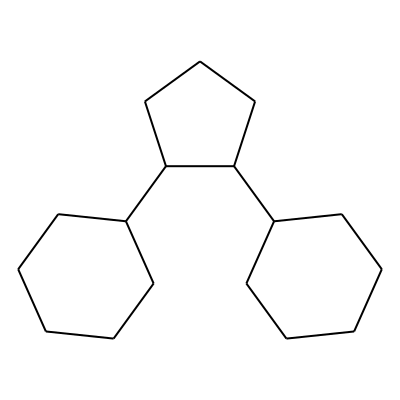
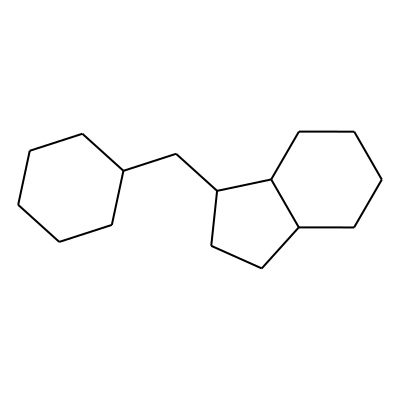
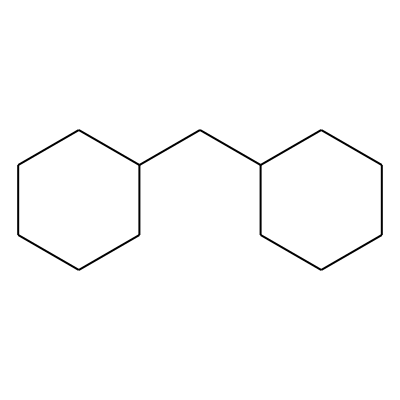
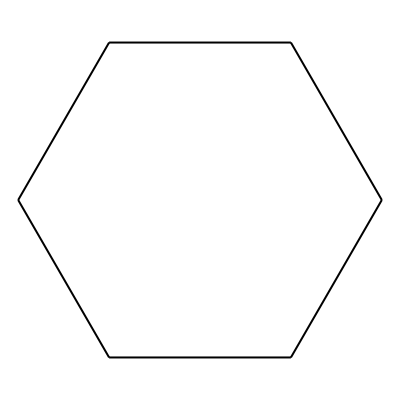
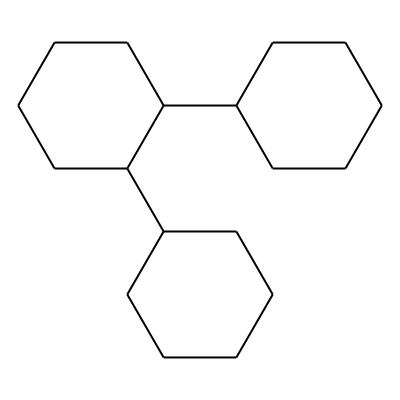
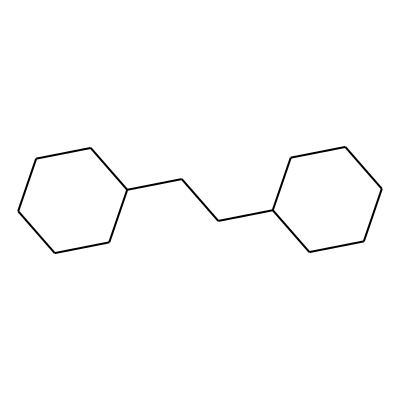
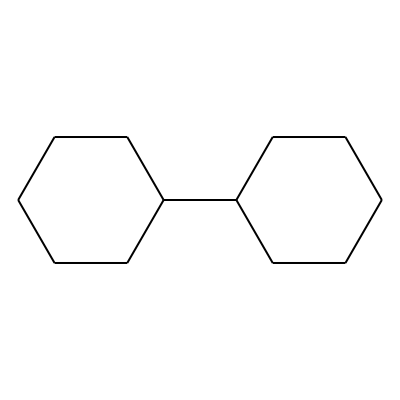
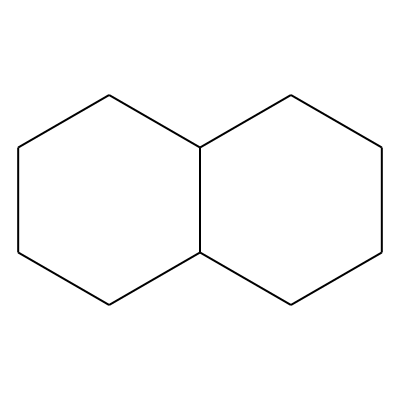
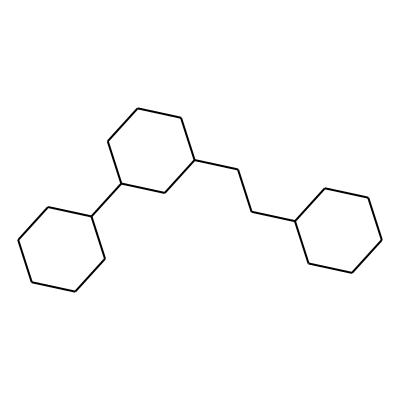
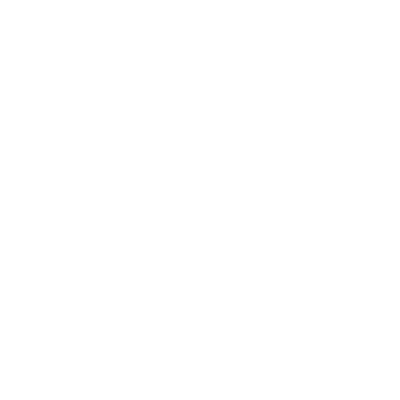

In [72]:
HTML(cox_active_scaffolds.head(10).to_html(formatters = {"mol": mol2display_png}, escape = False))